<a href="https://colab.research.google.com/github/itsxffan/TSDR_System_Python/blob/main/TSDR_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Mar 20 22:56:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
# Prerequisite Libaries
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F
import torchvision.transforms as T

from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from collections import defaultdict
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Downloading the Dataset from German Traffic Sign Dataset Source:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [24]:
TSDR_Train_Data = sorted(glob('GTSRB/Final_Training/Images/*'))
class_number = len(TSDR_Train_Data)
print("No of Traffic Sign Classes: " + str(class_number))

No of Traffic Sign Classes: 43


# **Exploring Dataset**

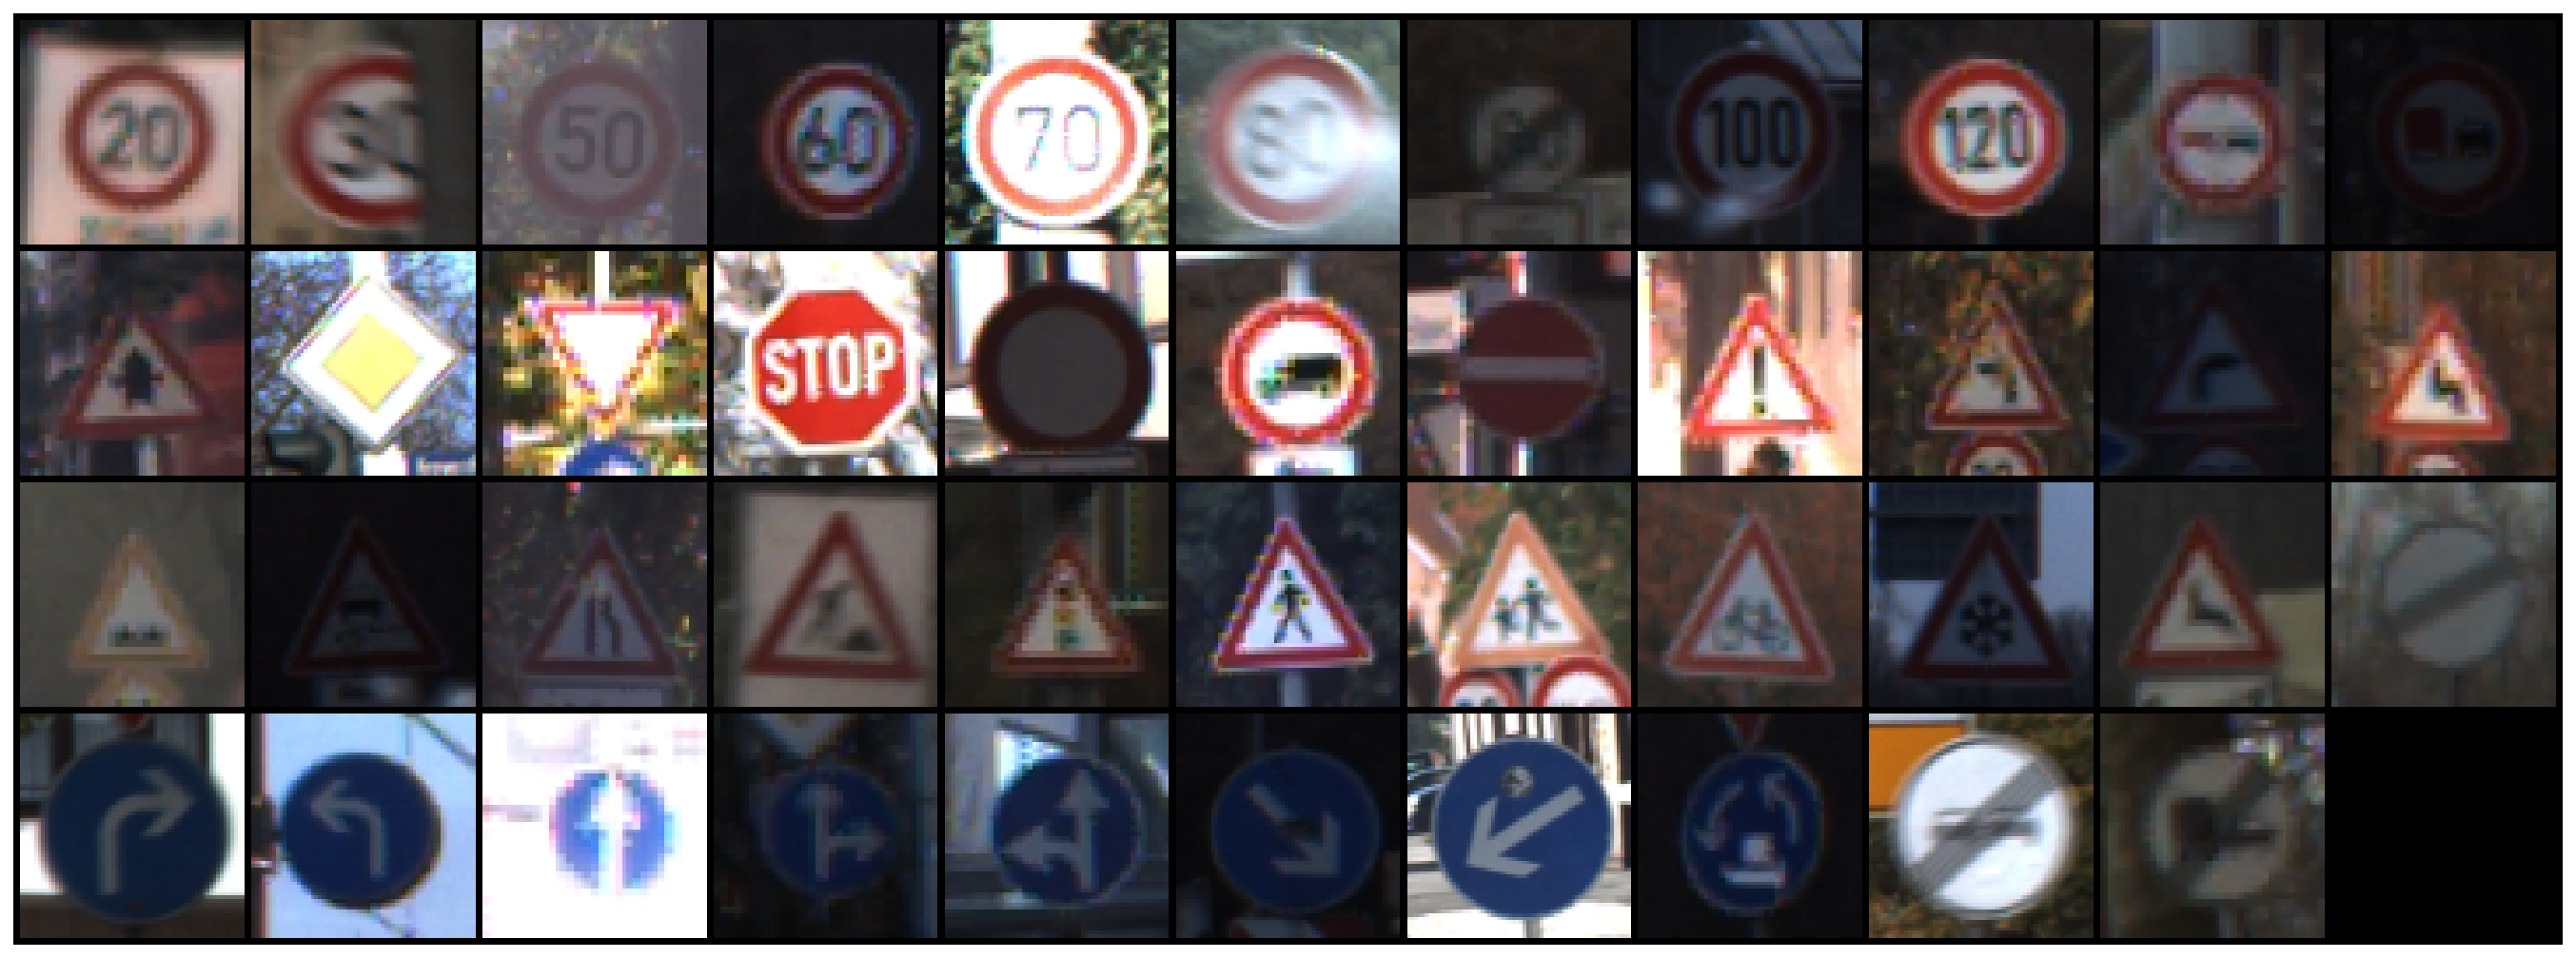

In [19]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in TSDR_Train_Data]
show_sign_grid(sample_images)

# Below is a set of traffic sign classes that have been randomly identified from the TSDR Traffic Sign Sample.

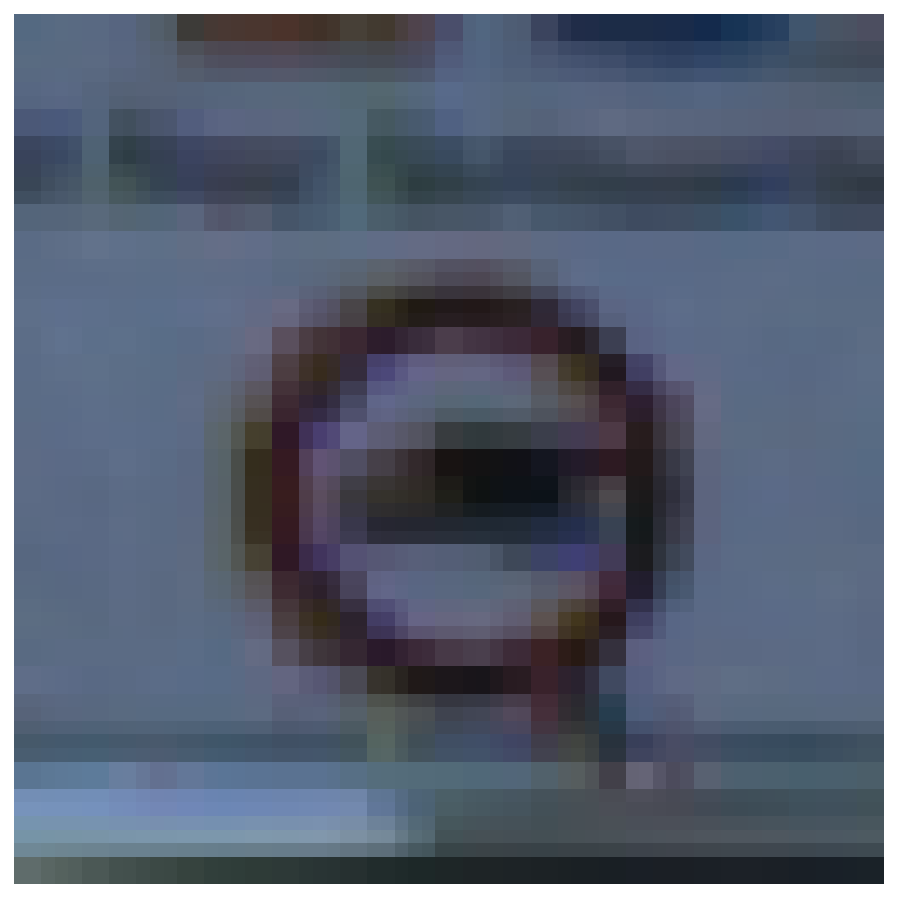

In [18]:
# Sample of a single-random Traffic Sign from the Dataset
img_path = glob(f'{TSDR_Train_Data[16]}/*ppm')[1]
show_image(img_path)

# **Organising Dataset**

In [25]:
'''
From the TSDR Dataset (GTSRB) collection I will initially start off classifying
most frequent Traffic Signs.
'''
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

